In [1]:
dataset = 'Heart'
seed = 0

In [2]:
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from experiments.utils import *
pd.set_option('future.no_silent_downcasting', True)

In [3]:
def preprocess_df(df):
    df_filtered = df[['val_score'] + df.filter(like='config').columns.tolist()]
    df_filtered.columns = df_filtered.columns.str.replace('config/', '', regex=False)
    
    df_filtered = df_filtered[df_filtered['val_score'] > 0]

    constants = {col: df_filtered[col].iloc[0] for col in df_filtered if df_filtered[col].nunique() == 1}

    df_filtered = df_filtered.replace({True: 1, False: 0, 'True': 1, 'False': 0, 'TRUE': 1, 'FALSE': 0})
    
    empty_cols = df_filtered.columns[df_filtered.isna().all()]

    df_filtered.drop(columns=['input_dim', 'hidden_dims', 'threshold_dim', 'threshold_init'], inplace=True, errors='ignore')
    df_filtered.drop(columns=constants.keys(), inplace=True, errors='ignore')
    df_filtered.drop(columns=empty_cols, inplace=True, errors='ignore')
    
    df_filtered = df_filtered.sort_values(by=['val_score'], ascending=False)
    
    df_filtered.reset_index(drop=True, inplace=True)
    
    return df_filtered

In [4]:
file_path = f"{get_params_path(dataset, seed)}/hpo.csv"
df = pd.read_csv(file_path)
df = preprocess_df(df)
df.head(10)

,val_score,learning_rate,num_hidden_layers,first_hl_size,last_hl_size_wrt_first,continuous_resolution,tau_out,grad_factor
0,0.858401,0.277201,4,55,0.263957,4,2.738010,1.118728
1,0.846217,0.029237,3,46,0.459203,4,2.034868,1.161310
2,0.845359,0.025964,4,32,0.785915,4,3.341233,1.229660
3,0.841584,0.038680,4,33,0.757473,4,7.233761,1.000432
4,0.840658,0.026494,4,35,0.724299,4,3.471271,1.003905
5,0.839458,0.064664,4,48,0.532099,6,4.429650,1.891773
6,0.837071,0.144554,5,47,0.318263,4,3.313500,1.496060
7,0.833834,0.276137,2,68,0.397697,4,1.258688,1.333155
8,0.831899,0.016262,3,26,0.472584,4,2.318346,1.235883
9,0.831402,0.137719,4,67,0.413068,4,1.769485,1.313958


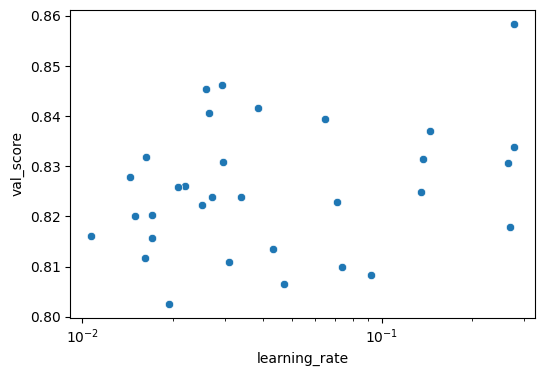

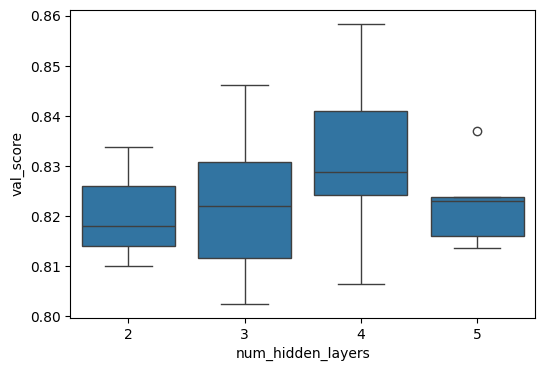

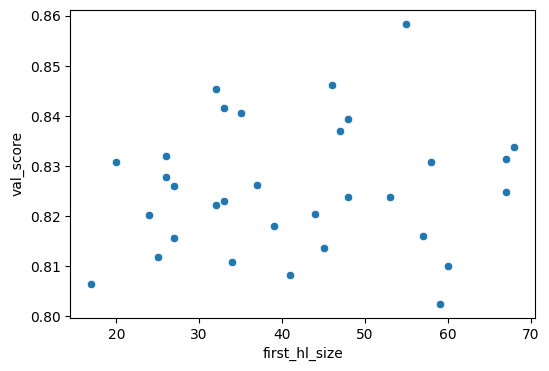

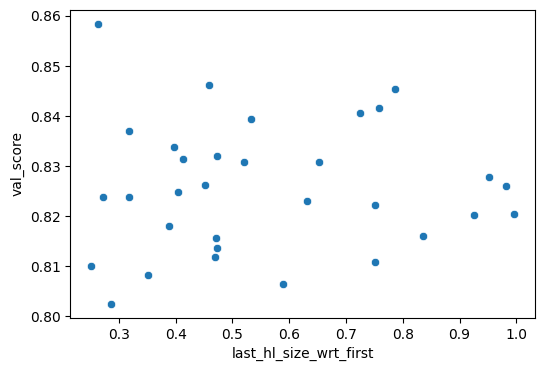

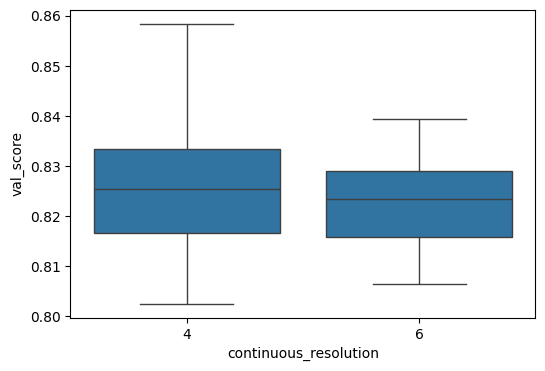

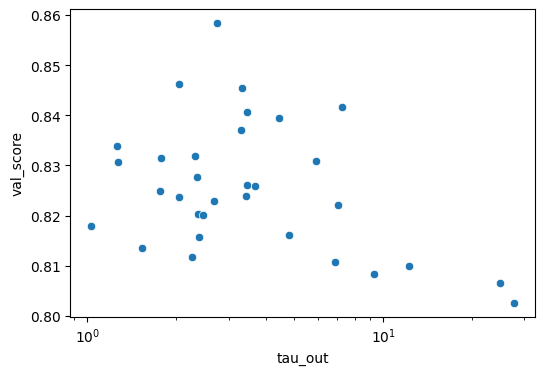

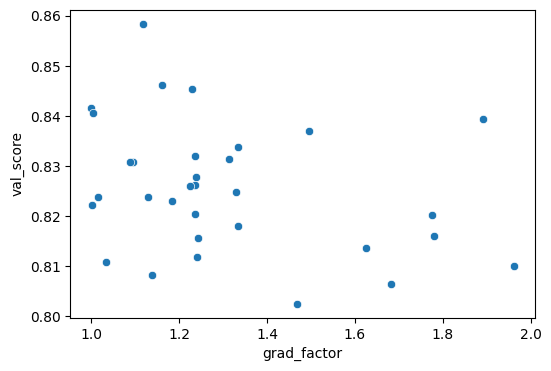

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")


cutoff = 10
categorical_cols = df.columns[df.nunique() <= cutoff].tolist()
categorical_cols = [col for col in categorical_cols if col != 'val_score']
numerical_cols = df.columns[df.nunique() > cutoff].tolist()
numerical_cols = [col for col in numerical_cols if col != 'val_score']

for col in df.columns:
    if col == 'val_score':
        continue
    plt.figure(figsize=(6, 4))
    if col in categorical_cols:
        sns.boxplot(x=df[col], y=df['val_score'])
    else:
        sns.scatterplot(x=df[col], y=df['val_score'])
        if max(df[col]) > min(df[col])*10:
            plt.xscale('log')
    plt.xlabel(col)
    plt.ylabel('val_score')
    plt.show()


In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

y = df['val_score']
X = df.drop('val_score', axis=1)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

X_processed = preprocessor.fit_transform(X)
features = numerical_cols + (list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)) if len(categorical_cols) > 0 else [])


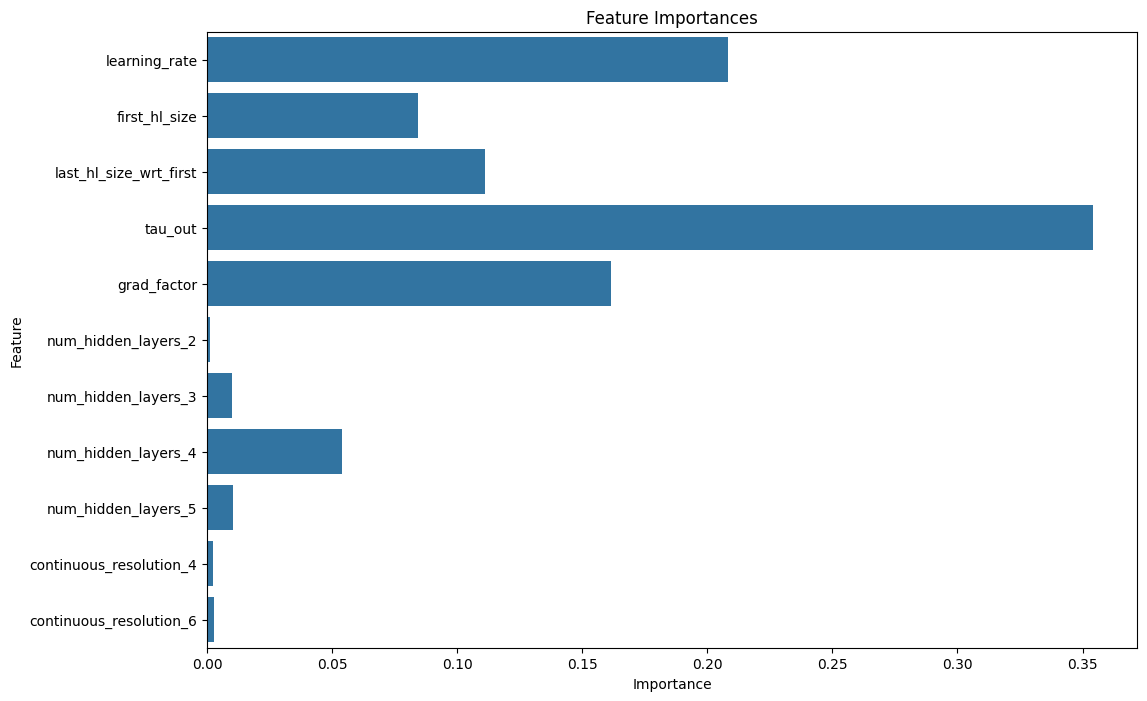

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_processed, y)

feature_importances = rf.feature_importances_

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [8]:
# import statsmodels.api as sm


# X_processed_df = pd.DataFrame(X_processed, columns=features)

# X_with_constant = sm.add_constant(X_processed_df)

# model = sm.OLS(y, X_with_constant).fit()

# print(model.summary())
